# Project Group - 

**Members:** 

Alex van Wijngaarden - 4874277

Eka Devi  Wulandari - 5912822

Nadhira Zahrani Widiafina - 5835429

Simon, van der Horst - 5125227

Wiet Kalf  - 4498445

# Research Objective

*Requires data modeling and quantitative research in Transport, Infrastructure & Logistics*


“How does the weather influence traffic accidents in cities and rural areas in the Netherlands during the period of 2021-2022, and how do these areas compare?”


# Contribution Statement

*Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling*

**Conceptulization:**
Alex, Eka, Nadhira, Simon, Wiet

**Data modeling (data pipeline):**
Wiet, Simon

**Data analysis (correlation heatmap):**
Wiet, Simon

**Data visualizaiton (plotly, seaborne etc):**
Nadhira, Eka

**Narative section (report):**
Alex


# Data Used

Dataset 1: Verkeersongevallen - Bestand geRegistreerde Ongevallen Nederland
https://data.overheid.nl/dataset/9841-verkeersongevallen---bestand-geregistreerde-ongevallen-nederland

Dataset 2: Additional data (population, area, density and road length) needed for the clustering analysis from CBS and wikipedia. Here are the links:
- density and area data: https://en.wikipedia.org/wiki/Municipalities_of_the_Netherlands
- length of road data: https://opendata.cbs.nl/statline/#/CBS/nl/dataset/70806ned/table?ts=1699173969758


# Report

## 1. Introduction
In the intricate tapestry of our daily lives, transport plays an important role. Going from A to B, people use many different modes to travel, whether by car, bus, bike or foot. Yet, while traveling, the potential for accidents lurks, influenced by an array of factors. One of these factors is the weather. To further understand how and why the weather plays a potential pivotal role in the amount of accidents in the Netherlands, a research question has been set:
[1] How does the weather influence traffic accidents in cities and rural areas in the Netherlands during the period of 2021-2022, and how do these areas compare?

In [25]:
import pandas as pd
import requests
from time import sleep
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import plotly.express as px
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

# 2. Data Processing
Columns necessary: \
AP3_CODE \
DOD \
LET \
UM \
WGD_CODE_1 \
BEBKOM \
MAXSNELHD\
IND_ALC

# Dataset 1

In [ ]:
#local absolute file path of large dataset
filename = r"C:\Users\simon\TIL jaar 1\TIL programming\project\traffic data\PGS0112-o-CSV-bestand-J-1-N-N-N\Ongevallengegevens\ongevallen.txt"
#loading the dataset
df = pd.read_csv(filename, encoding = 'latin1', low_memory=False)
# alcohol indicator for no was an empty column so that is filled with an n
df["IND_ALC"].fillna("N", inplace = True) 
#selecting the necessary columns
data = df[["AP3_CODE", "WGD_CODE_1", "BEBKOM", "MAXSNELHD", "IND_ALC", "GME_NAAM", "PVE_NAAM", "DISTRNAAM"]]
#dropping rows where either 1 of the columns has no value, reduces the amount of rows by approximately half
print(data)
data_cleaned = data.dropna()
print(data_cleaned)
#converting the dataframe to a .pkl file format for easier sharing
data_cleaned.to_pickle("accidents.pkl") #Dataset 1

# Dataset 2

In [ ]:
# Adding data reference from CBS for clustering analysis
clustering_raw_data = r"C:\Users\simon\TIL jaar 1\TIL programming\Project Group - Eka\municipality_clustering_data.csv"
df_cluster_data = pd.read_csv(clustering_raw_data, encoding = 'latin1', low_memory=False)

# Display only the relevant / needed columns
df_cluster_data = df_cluster_data [['Municipality_final','Population','Area','Density','Road_Length']]
df_cluster_data = df_cluster_data.rename(columns={'Municipality_final': 'Municipality_Name'}) 

In [26]:
df_accidents = pd.read_pickle("accidents.pkl")
print(df_accidents)

       AP3_CODE WGD_CODE_1 BEBKOM  MAXSNELHD IND_ALC          GME_NAAM  \
12          DOD          D     BU      100.0       N         Amsterdam   
15          DOD          D     BI      100.0       N           Tilburg   
16          DOD          D     BU       80.0       N  's-Hertogenbosch   
30          UMS          D     BU       80.0       N   Súdwest-Fryslân   
31          UMS          D     BU      100.0       N    Smallingerland   
...         ...        ...    ...        ...     ...               ...   
113135      UMS          D     BU       30.0       N            Voorst   
113136      UMS          D     BU      100.0       N           Nijkerk   
113140      UMS          D     BU      100.0       N         Rotterdam   
113149      UMS          D     BU       30.0       N    Haarlemmermeer   
113154      UMS          D     BU      100.0       N         Hoogeveen   

             PVE_NAAM           DISTRNAAM  
12      Noord-Holland   WNN District Zuid  
15      Noord-Brabant  

# 3. Descriptive Analysis of the Data

### 3.1 Accident and Heatmap Visualization

Section 3.1 focuses on the synthesis of accident data with geospatial analysis to create an intuitive heatmap visualization. This method graphically represents the density and distribution of traffic accidents, offering a clear visual summary of areas with higher and lower incident frequencies. Heatmaps are particularly effective in revealing hotspots and patterns that might not be immediately apparent from raw data, thereby providing valuable insights for further investigation and targeted safety measures.

### 3.1.1 Display Municipality Information

The visualization process begins by identifying and enumerating the unique municipalities involved in the traffic accident dataset. Utilizing the GME_NAAM column, the code snippet isolates each distinct municipality and computes the total count of such unique entities. This preliminary step is instrumental in the preparation for subsequent visual mapping. The output, which includes both a count and a detailed list of these municipalities, serves as a cornerstone for the accurate plotting of incidents in the following stages of analysis. It ensures that the data fed into the heatmap visualization is well-structured and comprehensive, reflecting the true breadth of the dataset's geographic coverage.

In [27]:
# Extract unique municipalities from the GME_NAAM column
unique_municipalities = df_accidents['GME_NAAM'].unique()

# Count of unique municipalities
num_unique_municipalities = df_accidents['GME_NAAM'].nunique()

print(f"Number of unique municipalities (GME_NAAM): {num_unique_municipalities}")
print("List of unique municipalities:")
for municipality in unique_municipalities[:5]:
    print(municipality)

Number of unique municipalities (GME_NAAM): 253
List of unique municipalities:
Amsterdam
Tilburg
's-Hertogenbosch
Súdwest-Fryslân
Smallingerland


### 3.1.2 Coordinates for Municipalities in the Netherlands: Longitude and Latitude Data

Prior to delving into the visualization of accident locations on the map, it is essential to gather accurate geographical coordinates for each municipality in the Netherlands. The dataset provided contains precise longitudinal and latitudinal points, which are crucial for plotting each location on the map. These coordinates serve as the foundational data that will enable the creation of an informative and detailed map, illustrating the spatial distribution of traffic incidents across the municipalities. With these coordinates, each municipality can be accurately represented on the map, providing a clear visual representation of the number of accidents in relation to their geographical context.

In [28]:
# this piece of code takes a while to run, be patient
def get_coordinates(municipality_name, country="Netherlands", max_retries=3, backoff_factor=0.3):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': f'{municipality_name}, {country}',
        'format': 'json',
        'limit': 1
    }
    
    session = requests.Session()
    retry = Retry(total=max_retries, backoff_factor=backoff_factor)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    session.headers.update({'User-Agent': 'YourAppName/1.0'})  # Add your User-Agent here

    try:
        response = session.get(base_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        if data:
            lat = float(data[0]['lat'])
            lon = float(data[0]['lon'])
            return lat, lon
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {municipality_name}: {e}")
    return None


# Sample municipalities
municipalities = [
    "Amsterdam", "Tilburg", "'s-Hertogenbosch", "Súdwest-Fryslân", "Smallingerland", 
    "Westerkwartier", "Oost Gelre", "Roerdalen", "Horst aan de Maas", "Venlo",
    "Breda", "Terneuzen", "Best", "Waddinxveen", "Weststellingwerf",
    "De Fryske Marren", "Leeuwarden", "Apeldoorn", "Barneveld", "Hattem",
    "Gilze en Rijen", "Rotterdam", "Schiedam", "Oosterhout", "Geertruidenberg",
    "Venray", "Neder-Betuwe", "Deventer", "Overbetuwe", "Nijmegen",
    "Purmerend", "Zuidplas", "'s-Gravenhage", "Leidschendam-Voorburg", "Weert",
    "Echt-Susteren", "Haarlemmermeer", "Rijswijk", "Koggenland", "Kaag en Braassem",
    "Moerdijk", "Vlissingen", "Oirschot", "Vught", "Maashorst", 
    "Opsterland", "Amersfoort", "Hollands Kroon", "Papendrecht", "Staphorst",
    "Waadhoeke", "Arnhem", "Leiden", "Wierden", "Noordoostpolder", 
    "Eindhoven", "Veldhoven", "Beuningen", "West Betuwe", "Land van Cuijk",
    "Heumen", "Utrecht", "Houten", "Utrechtse Heuvelrug", "Oostzaan",
    "Beverwijk", "Zaanstad", "Alkmaar", "Lansingerland", "Vlaardingen",
    "Midden-Delfland", "Heemskerk", "Dordrecht", "Hoeksche Waard", "Zwijndrecht",
    "Zoetermeer", "Heerenveen", "Sittard-Geleen", "Heerlen", "Ouder-Amstel",
    "Peel en Maas", "Almelo", "Lelystad", "Almere", "Tynaarlo",
    "Twenterand", "Wijchen", "Vijfheerenlanden", "Ridderkerk", "Barendrecht",
    "Wormerland", "Alblasserdam", "Etten-Leur", "Harderwijk", "Diemen",
    "Wassenaar", "Albrandswaard", "Maasgouw", "Maastricht", "Beekdaelen",
    "Meerssen", "Leudal", "Raalte", "Eemnes", "De Bilt",
    "Woerden", "Zaltbommel", "Ommen", "Zwolle", "Den Helder",
    "Borne", "Castricum", "Waalwijk", "Son en Breugel", "Sluis",
    "Oss", "Bodegraven-Reeuwijk", "Gouda", "Gooise Meren", "Amstelveen",
    "Hellevoetsluis", "Velsen", "Kampen", "Steenwijkerland", "Rucphen",
    "Bergen op Zoom", "Enschede", "Oude IJsselstreek", "Alphen aan den Rijn", "Meierijstad",
    "Geldrop-Mierlo", "Uitgeest", "Cranendonck", "De Ronde Venen", "Sliedrecht",
    "Tiel", "Culemborg", "Losser", "Veenendaal", "Waalre",
    "Stichtse Vecht", "Beek", "Bernheze", "Groningen", "Goeree-Overflakkee",
    "Heusden", "Gennep", "Laren", "Zeist", "Leiderdorp",
    "Maasdriel", "Valkenburg aan de Geul", "Reimerswaal", "Boxtel", "Westland",
    "Delft", "Emmen", "Leusden", "Soest", "Gorinchem",
    "Midden-Groningen", "Hoogeveen", "Kapelle", "Altena", "Halderberge",
    "Roosendaal", "Woensdrecht", "Eersel", "Aa en Hunze", "Meppel",
    "Schouwen-Duiveland", "Hardinxveld-Giessendam", "Ede", "Putten", "Hengelo",
    "Bergen (NH.)", "Zoeterwoude", "Beesel", "Oldambt", "Nunspeet",
    "Veendam", "Lingewaard", "Blaricum", "Medemblik", "Assen",
    "Middelburg", "Haaksbergen", "Haarlem", "De Wolden", "Goes",
    "Someren", "Roermond", "Westerveld", "Stein", "Voerendaal",
    "Nieuwegein", "Hilvarenbeek", "Schagen", "Epe", "Doetinchem",
    "Hendrik-Ido-Ambacht", "Duiven", "Alphen-Chaam", "Heeze-Leende", "Nijkerk",
    "Renkum", "Hellendoorn", "Rijssen-Holten", "Buren", "Oldebroek",
    "Eemsdelta", "Steenbergen", "Midden-Drenthe", "Zevenaar", "Heerde",
    "Hilversum", "Berkelland", "Bladel", "Harlingen", "Baarn",
    "Montferland", "Teylingen", "Dinkelland", "Deurne", "Oldenzaal",
    "Voorst", "Capelle aan den IJssel", "Coevorden", "Heiloo", "Bunnik",
    "Veere", "Rheden", "Ermelo", "Lisse", "Bunschoten",
    "Oegstgeest", "Zeewolde", "Brielle", "Elburg", "Edam-Volendam",
    "Drimmelen", "Dronten", "Huizen", "Tytsjerksteradiel", "Valkenswaard",
    "Oisterwijk", "Hardenberg", "Noord-Beveland", "Woudenberg", "Molenlanden",
    "Dalfsen", "Hulst", "Zandvoort", "Tholen", "IJsselstein",
    "Katwijk", "Voorburg", "Mook en Middelaar", "Scherpenzeel", "Brunssum",
    "Weesp", "Borger-Odoorn", "Goirle", "Grave", "Reusel-De Mierden",
    "Noordenveld", "Vaals", "Achtkarspelen", "Loppersum", "Gulpen-Wittem",
    "Bronckhorst", "Hoorn", "Eijsden-Margraten"
]

# Replace this list with all 253 municipalities
municipality_coords = {}

for municipality in municipalities:
    sleep(1)  # To comply with rate limiting
    coords = get_coordinates(municipality)
    if coords:
        municipality_coords[municipality] = coords

print(municipality_coords)


{'Amsterdam': (52.3730796, 4.8924534), 'Tilburg': (51.58561845, 5.0660616131367675), "'s-Hertogenbosch": (51.6889387, 5.303116), 'Súdwest-Fryslân': (52.974832649999996, 5.436073892467922), 'Smallingerland': (53.11525265, 6.050738915587699), 'Westerkwartier': (53.21425645, 6.3459813379440115), 'Oost Gelre': (52.0153031, 6.561010327461534), 'Roerdalen': (51.1454691, 6.034390914431709), 'Horst aan de Maas': (51.4515953, 6.030898893223135), 'Venlo': (51.39244885, 6.1511724144122955), 'Breda': (51.5887845, 4.7760237), 'Terneuzen': (51.29884295, 3.8422043956030683), 'Best': (51.5033671, 5.3938665), 'Waddinxveen': (52.0443437, 4.641596120380745), 'Weststellingwerf': (52.87191835, 6.008674359652279), 'De Fryske Marren': (52.9118448, 5.713876378916552), 'Leeuwarden': (53.2005936, 5.7918548), 'Apeldoorn': (52.17957375, 5.930077460807249), 'Barneveld': (52.17150665, 5.645439299954028), 'Hattem': (52.476711699999996, 6.061913261141655), 'Gilze en Rijen': (51.56323905, 4.913039391005126), 'Rotterda

### 3.1.3 Visual (Graphical) Representation of Traffic Incidents by Municipality in the Netherlands

This analysis explores the distribution and frequency of accidents within The Netherland's municipalities. Data visualization techniques are employed to offer a lucid and informative perspective on traffic safety. The ensuing charts and heatmaps provide insight into the areas with the most reported accidents, pinpointing regions that might require enhanced traffic safety interventions. Such visual data representation not only clarifies the present road safety conditions in the Netherlands but also acts as a valuable resource for policymakers and public safety officials striving to address and reduce traffic-related issues.

In [30]:
# Load accident data from the .pkl file
df_accidents = pd.read_pickle("accidents.pkl")

municipality_coords = {
    'Amsterdam': (52.3730796, 4.8924534), 
    'Tilburg': (51.58561845, 5.0660616131367675), 
    "'s-Hertogenbosch": (51.6889387, 5.303116), 
    'Súdwest-Fryslân': (52.974832649999996, 5.436073892467922), 
    'Smallingerland': (53.11525265, 6.050738915587699), 
    'Westerkwartier': (53.21425645, 6.3459813379440115), 
    'Oost Gelre': (52.0153031, 6.561010327461534), 
    'Roerdalen': (51.1454691, 6.034390914431709), 
    'Horst aan de Maas': (51.4515953, 6.030898893223135), 
    'Venlo': (51.39244885, 6.1511724144122955), 
    'Breda': (51.5887845, 4.7760237), 
    'Terneuzen': (51.29884295, 3.8422043956030683), 
    'Best': (51.5033671, 5.3938665), 
    'Waddinxveen': (52.0443437, 4.641596120380745), 
    'Weststellingwerf': (52.87191835, 6.008674359652279), 
    'De Fryske Marren': (52.9118448, 5.713876378916552), 
    'Leeuwarden': (53.2005936, 5.7918548), 
    'Apeldoorn': (52.17957375, 5.930077460807249), 
    'Barneveld': (52.17150665, 5.645439299954028), 
    'Hattem': (52.476711699999996, 6.061913261141655), 
    'Gilze en Rijen': (51.56323905, 4.913039391005126), 
    'Rotterdam': (51.9244424, 4.47775), 
    'Schiedam': (51.9300454, 4.386451052615731), 
    'Oosterhout': (51.632237599999996, 4.863042417836681), 
    'Geertruidenberg': (51.6961662, 4.877843805275408), 
    'Venray': (51.5082754, 5.958901096612693), 
    'Neder-Betuwe': (51.92150995, 5.616123265710504), 
    'Deventer': (52.2695736, 6.236339604766698), 
    'Overbetuwe': (51.921961249999995, 5.786081524088322), 
    'Nijmegen': (51.842574850000005, 5.838960628748229), 
    'Purmerend': (52.5024789, 4.9614827), 
    'Zuidplas': (51.9995787, 4.613450887425165), 
    "'s-Gravenhage": (52.07494555, 4.2696802205364515), 
    'Leidschendam-Voorburg': (52.09260105, 4.4321249720751625), 
    'Weert': (51.235582949999994, 5.705079711646853), 
    'Echt-Susteren': (51.082135199999996, 5.899125547533698), 
    'Haarlemmermeer': (52.3238421, 4.715261248876009), 
    'Rijswijk': (52.0446265, 4.3188215), 
    'Koggenland': (52.64758125, 4.952321716593174), 
    'Kaag en Braassem': (52.193046249999995, 4.621636649034843), 
    'Moerdijk': (51.66277225, 4.525592262905145), 
    'Vlissingen': (51.49433865, 3.415005767601362), 
    'Oirschot': (51.488961599999996, 5.300594979407693), 
    'Vught': (51.6511806, 5.23680014410728), 
    'Maashorst': (51.69520705, 5.657493808428191), 
    'Opsterland': (53.04680105, 6.095135723829035), 
    'Amersfoort': (52.1562499, 5.3896944), 
    'Hollands Kroon': (52.875946799999994, 4.965504712047365), 
    'Papendrecht': (51.834666999999996, 4.704688255674374), 
    'Staphorst': (52.6368387, 6.208129727382328), 
    'Waadhoeke': (53.2460054, 5.610797779708593), 
    'Arnhem': (52.0056642, 5.8762345077641305), 
    'Leiden': (52.1594747, 4.4908843), 
    'Wierden': (52.35195215, 6.567448420567358), 
    'Noordoostpolder': (52.72520455, 5.705372865399351), 
    'Eindhoven': (51.4392648, 5.478633), 
    'Veldhoven': (51.4190691, 5.4045572), 
    'Beuningen': (51.8586611, 5.767357), 
    'West Betuwe': (51.8697052, 5.1941371524390245), 
    'Land van Cuijk': (51.6635613, 5.851042081979072), 
    'Heumen': (51.78111135, 5.824896568483027), 
    'Utrecht': (52.080985600000005, 5.12768396945229), 
    'Houten': (52.03061555, 5.161216639426677), 
    'Utrechtse Heuvelrug': (52.028653649999995, 5.394884269227865), 
    'Oostzaan': (52.45218065, 4.868548732505015), 
    'Beverwijk': (52.4876371, 4.6603502), 
    'Zaanstad': (52.4689235, 4.773783522451712), 
    'Alkmaar': (52.600853799999996, 4.817099446443963), 
    'Lansingerland': (52.01101685, 4.507645445233463), 
    'Vlaardingen': (51.9227863, 4.329563378870851), 
    'Midden-Delfland': (51.97058165, 4.322980951300874), 
    'Heemskerk': (52.51011775, 4.635060887073173), 
    'Dordrecht': (51.7958812, 4.6779351), 
    'Hoeksche Waard': (51.76743725, 4.435615258877212), 
    'Zwijndrecht': (51.8162227, 4.6405166), 
    'Zoetermeer': (52.06228915, 4.487754536970652), 
    'Heerenveen': (52.998474200000004, 5.923148795038062), 
    'Sittard-Geleen': (51.0094043, 5.8376057867167965), 
    'Heerlen': (50.8775239, 5.981506585454879), 
    'Ouder-Amstel': (52.2946678, 4.91646890749465), 
    'Peel en Maas': (51.33064175, 5.979363705773345), 
    'Almelo': (52.3567956, 6.66725277634109), 
    'Lelystad': (52.536680950000004, 5.361043525412799), 
    'Almere': (52.44175125, 5.2092943104327585), 
    'Tynaarlo': (53.11201305, 6.5598426150845), 
    'Twenterand': (52.439304, 6.635427575044659), 
    'Wijchen': (51.82025285, 5.696090348571646), 
    'Vijfheerenlanden': (51.9302055, 5.0495233241373185), 
    'Ridderkerk': (51.8714812, 4.5999778), 
    'Barendrecht': (51.85193795, 4.52938352520747), 
    'Wormerland': (52.505611200000004, 4.859412783877223), 
    'Alblasserdam': (51.8599524, 4.666202275442476), 
    'Etten-Leur': (51.5692065, 4.6360813), 
    'Harderwijk': (52.33599915, 5.640271521392062), 
    'Diemen': (52.3350493, 4.984282926187014), 
    'Wassenaar': (52.14361135, 4.370966818678455), 
    'Albrandswaard': (51.8524269, 4.435285362646326), 
    'Maasgouw': (51.1577134, 5.894547348825503), 
    'Maastricht': (50.85798545, 5.6969881818221095), 
    'Beekdaelen': (50.93449595, 5.88869051100548), 
    'Meerssen': (50.90470915, 5.735207828646779), 
    'Leudal': (51.2339148, 5.895853139985457), 
    'Raalte': (52.3874327, 6.307848238791079), 
    'Eemnes': (52.2547415, 5.286070995513654), 
    'De Bilt': (52.1445592, 5.173777333788463), 
    'Woerden': (52.08701595, 4.876687198673499), 
    'Zaltbommel': (51.782164, 5.189826737158967), 
    'Ommen': (52.510346999999996, 6.452424670840507), 
    'Zwolle': (52.514565250000004, 6.097720359677693), 
    'Den Helder': (52.9529894, 4.8267592494488), 
    'Borne': (52.3004342, 6.754922548726859), 
    'Castricum': (52.558830549999996, 4.639675526200153), 
    'Waalwijk': (51.687337150000005, 5.017307939950269), 
    'Son en Breugel': (51.5173136, 5.500838), 
    'Sluis': (51.32566285, 3.5166308518864264), 
    'Oss': (51.778354199999995, 5.532083610932192), 
    'Bodegraven-Reeuwijk': (52.0677553, 4.7575800066386025), 
    'Gouda': (52.018119350000006, 4.711122134697802), 
    'Gooise Meren': (52.322224000000006, 5.104556785563771), 
    'Amstelveen': (52.2862177, 4.852649259746028), 
    'Hellevoetsluis': (51.833921, 4.1436739), 
    'Velsen': (52.451910299999994, 4.603891145874141), 
    'Kampen': (52.5559484, 5.9033303), 
    'Steenwijkerland': (52.747874100000004, 6.023206628871991), 
    'Rucphen': (51.5209462, 4.569368236553837), 
    'Bergen op Zoom': (51.4944756, 4.2871541), 
    'Enschede': (52.2209855, 6.8940537), 
    'Oude IJsselstreek': (51.90269995, 6.391753286370878), 
    'Alphen aan den Rijn': (52.1131403, 4.6408411999450685), 
    'Meierijstad': (51.58844725, 5.516390104700668), 
    'Geldrop-Mierlo': (51.43182315, 5.5918099053219965), 
    'Uitgeest': (52.5303233, 4.7090367), 
    'Cranendonck': (51.286919, 5.5810952873530475), 
    'De Ronde Venen': (52.2325145, 4.920240947843794), 
    'Sliedrecht': (51.8308564, 4.76984303118367), 
    'Tiel': (51.892425349999996, 5.430438174137935), 
    'Culemborg': (51.94933145, 5.209215154667634), 
    'Losser': (52.300289, 6.988104272999393), 
    'Veenendaal': (52.02320415, 5.551800233162295), 
    'Waalre': (51.3856734, 5.466115689689311), 
    'Stichtse Vecht': (52.20301145, 4.994837650454457), 
    'Beek': (50.926876899999996, 5.810685055558121), 
    'Bernheze': (51.683532850000006, 5.521242816477055), 
    'Groningen': (53.2190652, 6.5680077), 
    'Goeree-Overflakkee': (51.75128625, 4.13576992064659), 
    'Heusden': (51.6888859, 5.165506991078929), 
    'Gennep': (51.6950839, 5.9734549), 
    'Laren': (52.2565894, 5.2251925), 
    'Zeist': (52.0892832, 5.2276307), 
    'Leiderdorp': (52.15705765, 4.543378647059756), 
    'Maasdriel': (51.7853378, 5.316792505584603), 
    'Valkenburg aan de Geul': (50.86094405, 5.813709999149556), 
    'Reimerswaal': (51.44300185, 4.101441031156753), 
    'Boxtel': (51.5890603, 5.315795445406877), 
    'Westland': (52.0014044, 4.201908937069459), 
    'Delft': (51.999457199999995, 4.362724538543995), 
    'Emmen': (52.75286615, 6.952513466208563), 
    'Leusden': (52.1187668, 5.417118899734083), 
    'Soest': (52.164475749999994, 5.295725560695609), 
    'Gorinchem': (51.8421872, 4.974600467260094), 
    'Midden-Groningen': (53.184673599999996, 6.7795735147296075), 
    'Hoogeveen': (52.7264258, 6.49308148854467), 
    'Kapelle': (51.4879711, 3.96063), 
    'Altena': (51.76974375, 4.943677659330839), 
    'Halderberge': (51.58976405, 4.513483321011281), 
    'Roosendaal': (51.5331484, 4.4561276), 
    'Woensdrecht': (51.4106688, 4.327761012867084), 
    'Eersel': (51.393329050000006, 5.341352630697114), 
    'Aa en Hunze': (52.9814393, 6.729452061777957), 
    'Meppel': (52.711744350000004, 6.197307325163717), 
    'Schouwen-Duiveland': (51.687435300000004, 3.876619717713044), 
    'Hardinxveld-Giessendam': (51.83862405, 4.824610423909343), 
    'Ede': (52.07168255, 5.745510631034939), 
    'Putten': (52.24773005, 5.57827393798401), 
    'Hengelo': (52.2658726, 6.7924049), 
    'Bergen (NH.)': (52.6702278, 4.7011616), 
    'Zoeterwoude': (52.11718945, 4.503459502079346), 
    'Beesel': (51.26998845, 6.073401860697201), 
    'Oldambt': (53.2223408, 7.068982392062174), 
    'Nunspeet': (52.3372909, 5.795636429005031), 
    'Veendam': (53.0807517, 6.877303483300453), 
    'Lingewaard': (51.9074337, 5.9439721314706215), 
    'Blaricum': (52.281133749999995, 5.29371090566366), 
    'Medemblik': (52.7907137, 5.16862281678412), 
    'Assen': (52.9952273, 6.560498), 
    'Middelburg': (51.4996784, 3.6137371), 
    'Haaksbergen': (52.1564581, 6.740239), 
    'Haarlem': (52.3885317, 4.6388048), 
    'De Wolden': (52.705585049999996, 6.338952403673677), 
    'Goes': (51.5031033, 3.8897596), 
    'Someren': (51.38632235, 5.688884477579495), 
    'Roermond': (51.1933903, 5.9882649), 
    'Westerveld': (52.828469850000005, 6.311221629926694), 
    'Stein': (50.9732145, 5.760681940061414), 
    'Voerendaal': (50.8722592, 5.913755707785212), 
    'Nieuwegein': (52.0298704, 5.0929333789192395), 
    'Hilvarenbeek': (51.48698395, 5.146972817481462), 
    'Schagen': (52.78822125, 4.741356804254988), 
    'Epe': (52.3270371, 5.9631945020748915), 
    'Doetinchem': (51.958534799999995, 6.281455126241391), 
    'Hendrik-Ido-Ambacht': (51.84664995, 4.634280416662918), 
    'Duiven': (51.9470218, 6.02303247329986), 
    'Alphen-Chaam': (51.50689565, 4.871359861218567), 
    'Heeze-Leende': (51.35863595, 5.5779773009269675), 
    'Nijkerk': (52.214853649999995, 5.478146323965094), 
    'Renkum': (51.99168495, 5.791692252659134), 
    'Hellendoorn': (52.39046275, 6.451511548705841), 
    'Rijssen-Holten': (52.284324850000004, 6.440777380657181), 
    'Buren': (51.92963705, 5.420000238944224), 
    'Oldebroek': (52.45673635, 5.951864370961877), 
    'Eemsdelta': (53.34781255, 6.795656528819859), 
    'Steenbergen': (51.603292100000004, 4.309251716161476), 
    'Midden-Drenthe': (52.87061935, 6.568055858657804), 
    'Zevenaar': (51.927908099999996, 6.077526279085048), 
    'Heerde': (52.4056303, 6.0413984003658525), 
    'Hilversum': (52.2241375, 5.1719396), 
    'Berkelland': (52.10152, 6.618404626883939), 
    'Bladel': (51.37121075, 5.234630644566941), 
    'Harlingen': (53.1752103, 5.4141998), 
    'Baarn': (52.2002549, 5.269143393313942), 
    'Montferland': (51.92400575, 6.205514601615217), 
    'Teylingen': (52.21739375, 4.511393222538171), 
    'Dinkelland': (52.371448799999996, 6.915066619316923), 
    'Deurne': (51.4281834, 5.828106871124028), 
    'Oldenzaal': (52.30853685, 6.914603743122237), 
    'Voorst': (52.2374112, 6.086274393475191), 
    'Capelle aan den IJssel': (51.9312552, 4.5883596), 
    'Coevorden': (52.6612281, 6.7407359), 
    'Heiloo': (52.60192475, 4.70503175175436), 
    'Bunnik': (52.039151849999996, 5.220319799249577), 
    'Veere': (51.55640385, 3.577269355747127), 
    'Rheden': (52.03136695, 6.060504296329905), 
    'Ermelo': (52.2858356, 5.654938589920705), 
    'Lisse': (52.2540183, 4.541928029675811), 
    'Bunschoten': (52.2391743, 5.3734101), 
    'Oegstgeest': (52.1833669, 4.472129402976295), 
    'Zeewolde': (52.3451194, 5.4580775473608565), 
    'Brielle': (51.901662, 4.1626292), 
    'Elburg': (52.415659149999996, 5.841321708557087), 
    'Edam-Volendam': (52.54861165, 5.0266156034337826),
    'Drimmelen': (51.69768865, 4.743934177567655), 
    'Dronten': (52.531389649999994, 5.750631211201343), 
    'Huizen': (52.296484449999994, 5.240582040690262), 
    'Tytsjerksteradiel': (53.20512135, 5.973447146507526), 
    'Valkenswaard': (51.3202409, 5.458181897733282), 
    'Oisterwijk': (51.56610775, 5.198644959051684), 
    'Hardenberg': (52.56982145, 6.633166913313982), 
    'Noord-Beveland': (51.56520675, 3.8009095733783114), 
    'Woudenberg': (52.08025955, 5.4122265761644925), 
    'Molenlanden': (51.891504350000005, 4.836502624912571), 
    'Dalfsen': (52.51178365, 6.256636721854065), 
    'Hulst': (51.33154005, 4.087702848747496), 
    'Zandvoort': (52.3713394, 4.5307624), 
    'Tholen': (51.57085015, 4.076142821673509), 
    'IJsselstein': (52.026205250000004, 5.028685923229064), 
    'Katwijk': (52.2005078, 4.4146372), 
    'Voorburg': (52.0703201, 4.3558561), 
    'Mook en Middelaar': (51.74830635, 5.906406373368311), 
    'Scherpenzeel': (52.0795901, 5.4904134), 
    'Brunssum': (50.9431108, 5.9705675), 
    'Weesp': (52.3072593, 5.0420822), 
    'Borger-Odoorn': (52.9000925, 6.8821614819282875), 
    'Goirle': (51.5056266, 5.033774070783131), 
    'Grave': (51.7596504, 5.7411125), 
    'Reusel-De Mierden': (51.37099705, 5.1468666691668705), 
    'Noordenveld': (53.0945705, 6.4209724500257455), 
    'Vaals': (50.7781016, 5.981067967268041), 
    'Achtkarspelen': (53.207516749999996, 6.150763705175438), 
    'Loppersum': (53.3320144, 6.7469502), 
    'Gulpen-Wittem': (50.79962605, 5.890529675273097), 
    'Bronckhorst': (52.0529087, 6.269274781349422), 
    'Hoorn': (52.653272, 5.0735802), 
    'Eijsden-Margraten': (50.80499415, 5.768281669696572)
}

# Group by GME_NAAM and count the number of accidents
df_grouped = df_accidents.groupby('GME_NAAM').size().reset_index(name='num_accidents')

# Merge with coordinates
df_grouped['latitude'] = df_grouped['GME_NAAM'].map(lambda x: municipality_coords.get(x, (np.nan, np.nan))[0])
df_grouped['longitude'] = df_grouped['GME_NAAM'].map(lambda x: municipality_coords.get(x, (np.nan, np.nan))[1])

# Remove rows with NaN coordinates (municipalities not in the dictionary)
df_grouped.dropna(subset=['latitude', 'longitude'], inplace=True)

# Define a threshold for displaying municipality names
threshold = 100

fig = px.density_mapbox(df_grouped, 
                        lat='latitude', 
                        lon='longitude', 
                        z='num_accidents', 
                        radius=10,  # Reduced radius for less blurriness
                        center=dict(lat=52.3, lon=5.5),  # Centering on Netherlands
                        zoom=6,
                        hover_name='GME_NAAM',
                        title="Number of Accidents by Municipality",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        template="plotly")

fig.update_layout(mapbox_style="carto-positron")

fig.show()


The image depicts a heatmap of the number of accidents by municipality in the Netherlands. The heatmap is color-coded based on the number of accidents, with the color scale shown on the right side indicating that darker shades of purple represent areas with more accidents, scaling from 1 to over 500.

The map allows for the visual identification of these municipalities through prominent purple spots. Large cities in the Netherlands, such as Rotterdam and Amsterdam, are depicted with large, dark purple bubbles, signifying a high concentration of accidents. Other municipalities are also represented with bubbles, which may appear slightly smaller or lighter in color, corresponding to a fewer number of accidents.

Moving from the visual cues on the heatmap to the empirical data, this table presents a quantitative snapshot of traffic accidents across various municipalities in the Netherlands, offering a focused look at the locations with the highest incidence rates. The data is organized to highlight the number of accidents in descending order, starting with Rotterdam at the forefront, followed by Amsterdam, and trailing down to Apeldoorn. Each entry correlates to a unique municipality, represented by its respective name under the column 'GME_NAAM', alongside the total count of recorded accidents in the 'num_accidents' column. The figures reflect a range of accident frequencies, providing a basis for understanding the distribution of traffic-related incidents in these urban areas.

In [31]:
# Sort the grouped DataFrame by 'num_accidents' in descending order
df_sorted = df_grouped.sort_values('num_accidents', ascending=False)

# Take the top 5 rows
top_5_municipalities = df_sorted.head(10)

# Print out the top 5 municipalities
print(top_5_municipalities[['GME_NAAM', 'num_accidents']])


             GME_NAAM  num_accidents
182         Rotterdam            543
13          Amsterdam            419
87     Haarlemmermeer            246
208           Utrecht            157
36              Breda            149
68          Eindhoven            146
0       's-Gravenhage            127
1    's-Hertogenbosch            117
217             Venlo            108
14          Apeldoorn            104


The table lists the number of traffic accidents in various Dutch municipalities, providing a snapshot of areas with the highest incidence of events. Rotterdam tops the table with 543 reported incidents, marking it as the municipality with the most accidents. Amsterdam is next with 419 accidents, underscoring its status as another focal point for traffic incidents. Further down, Haarlemmermeer, Utrecht, and Breda also report significant numbers, though not as high as the leading cities. Additional municipalities like Eindhoven, 's-Gravenhage, and 's-Hertogenbosch are noted, each with accidents totaling over a hundred, ending with Venlo and Apeldoorn. This information is key to identifying and understanding the patterns of traffic-related incidents in these populated areas.

### 3.1.4 Visual (Graphical) Representation of Traffic Incidents by Province in the Netherlands

Building on the analysis of traffic incidents at the municipal level, the scope now extends to the examination of accident patterns across the provinces of the Netherlands. The data aggregated at this higher administrative level reveals regional trends and identifies provinces with higher frequencies of traffic-related events. This comparative view highlights the volume of accidents within each province and offers insights into potential underlying factors contributing to regional differences. The ensuing discussion aims to deliver a comprehensive understanding of the distribution of traffic accidents across the Dutch provinces.

In [32]:
import pandas as pd
import plotly.express as px

provinces = {
    'North Holland': ['Amsterdam', 'Haarlem', 'Hilversum', 'Purmerend', 'Zandvoort'],
    'South Holland': ['Rotterdam', 's-Gravenhage', 'Leiden', 'Delft', 'Schiedam', 's-Gravenzande', 'Zoetermeer', 'Rijswijk', 'Pijnacker-Nootdorp', 'Wassenaar', 'Krimpen aan den IJssel', 'Vlaardingen', 'Midden-Delfland', 'Westland', 'Lansingerland', 'Koggenland', 'Kaag en Braassem', 'Moerdijk', 'Albrandswaard', 'Nissewaard', 'Alphen aan den Rijn', 'Teylingen', 'Capelle aan den IJssel', 'Krimpenerwaard', 'Hoeksche Waard', 'Zwijndrecht'],
    'Zeeland': ['Vlissingen', 'Kapelle', 'Schouwen-Duiveland', 'Borsele', 'Noord-Beveland', 'Tholen', 'Veere'],
    'Drenthe': [
        'Aa en Hunze', 'Assen', 'Borger-Odoorn', 'Coevorden', 'De Wolden',
        'Emmen', 'Hoogeveen', 'Meppel', 'Midden-Drenthe', 'Noordenveld',
        'Tynaarlo', 'Westerveld'
    ],
    'Flevoland': [
        'Almere', 'Dronten', 'Lelystad', 'Noordoostpolder', 'Urk', 'Zeewolde'
    ],
    'Friesland': [
        'De Fryske Marren', 'Heerenveen', 'Leeuwarden', 'Opsterland',
        'Smallingerland', 'Súdwest-Fryslân', 'Tytsjerksteradiel', 'Waadhoeke'
    ],
    'Gelderland': [
        'Aalten', 'Apeldoorn', 'Arnhem', 'Beuningen', 'Berg en Dal', 'Berkelland',
        'Beuningen', 'Buren', 'Culemborg', 'Doesburg', 'Doetinchem', 'Druten',
        'Duiven', 'Ede', 'Elburg', 'Epe', 'Ermelo', 'Geldrop-Mierlo', 'Harderwijk',
        'Hattem', 'Heerde', 'Heumen', 'Lingewaard', 'Lochem', 'Maasdriel', 'Montferland',
        'Nijkerk', 'Nijmegen', 'Nunspeet', 'Oldebroek', 'Oost Gelre', 'Ooststellingwerf',
        'Oude IJsselstreek', 'Overbetuwe', 'Putten', 'Renkum', 'Rheden', 'Rijssen-Holten',
        'Rozendaal', 'Scherpenzeel', 'Tiel', 'Voorst', 'Wageningen', 'West Betuwe',
        'West Maas en Waal', 'Westervoort', 'Wijchen', 'Winterswijk', 'Zaltbommel',
        'Zevenaar', 'Gennep', 'Buren', 'Lingewaard', 'Overbetuwe', 'West Betuwe',
        'Montferland', 'Oude IJsselstreek', 'Winterswijk', 'Voorst', 'Doetinchem',
        'West Maas en Waal', 'Nijkerk', 'Heerde', 'Epe', 'Berkelland', 'Bronckhorst',
        'Lochem', 'Oost Gelre', 'Aalten', 'Zutphen'
    ],
    'Groningen': [
        'Eemsdelta', 'Groningen', 'Het Hogeland', 'Midden-Groningen', 'Oldambt',
        'Pekela', 'Stadskanaal', 'Veendam', 'Westerkwartier', 'Westerwolde'
    ],
    'Limburg': [
        'Beek', 'Beekdaelen', 'Beesel', 'Bergen', 'Brunssum', 'Echt-Susteren',
        'Gulpen-Wittem', 'Heerlen', 'Horst aan de Maas', 'Kerkrade', 'Landgraaf',
        'Leudal', 'Maastricht', 'Maasgouw', 'Meerssen', 'Mook en Middelaar',
        'Nederweert', 'Peel en Maas', 'Roermond', 'Simpelveld', 'Sittard-Geleen',
        'Stein', 'Vaals', 'Valkenburg aan de Geul', 'Venlo', 'Venray', 'Voerendaal',
        'Weert'
    ],
    'Noord-Brabant': [
        'Alphen-Chaam', 'Altena', 'Baarle-Nassau', 'Hilvarenbeek', 'Goirle',
        'Reusel-De Mierden', 'Eersel', 'Bladel', 'Oirschot', 'Best', 'Veldhoven',
        'Eindhoven', 'Oisterwijk', 'Haaren', 'Tilburg', "'s-Hertogenbosch",
        'Meierijstad', 'Sint-Michielsgestel', 'Boxtel', 'Haaren', 'Vught', 'Dongen',
        'Loon op Zand', 'Gilze en Rijen', 'Tilburg', 'Gilze en Rijen',
        'Geertruidenberg', 'Oosterhout', 'Waalwijk', 'Heusden', 'Altena'
    ],
    'Utrecht': [
        'Eemnes', 'De Bilt', 'Stichtse Vecht', 'Baarn', 'Nieuwegein', 'Woudenberg',
        'Utrecht', 'Houten', 'Lopik', 'Vijfheerenlanden', 'Woerden', 'Zeist'
    ]
}


# Data
data = {
    'Province': ['North Holland', 'South Holland', 'Zeeland', 'Drenthe', 'Flevoland', 
                 'Friesland', 'Gelderland', 'Groningen', 'Limburg', 'Noord-Brabant', 'Utrecht'],
    'Total accidents': [465, 1198, 40, 171, 133, 259, 823, 198, 478, 757, 386]
}

coordinates = {
    'North Holland': (52.6323814, 4.7533755),
    'South Holland': (51.9225, 4.47917),
    'Zeeland': (51.4991747, 3.6151451),
    'Drenthe': (52.8775717, 6.6178052),
    'Flevoland': (52.5246256, 5.7400598),
    'Friesland': (53.1641641, 5.7763946),
    'Gelderland': (52.0583672, 5.5363016),
    'Groningen': (53.2190652, 6.5680077),
    'Limburg': (51.2091958, 5.9925004),
    'Noord-Brabant': (51.5287863, 5.5592763),
    'Utrecht': (52.0809856, 5.1276839)
}

df = pd.DataFrame(data)
df['Latitude'] = df['Province'].apply(lambda x: coordinates[x][0])
df['Longitude'] = df['Province'].apply(lambda x: coordinates[x][1])

# Create a density_mapbox figure
fig = px.density_mapbox(df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Total accidents', 
                        radius=20,  # Adjust radius as needed
                        center=dict(lat=52.3, lon=5.5),  # Centering on Netherlands
                        zoom=6,
                        hover_name='Province',
                        title="Number of Accidents by Province",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        template="plotly")

# Update the layout to use a mapbox style
fig.update_layout(mapbox_style="carto-positron")

# Display the figure
fig.show()


The image displays a heatmap on a map of the Netherlands, showing the distribution of traffic accidents by province. The intensity of the accidents is visualized by color-coded circles, with the color scale on the right indicating the number of accidents. Darker shades of purple signify a higher number of accidents, scaling from 200 to over 1000, as indicated by the color legend labeled "Total accidents."

The largest and darkest bubble is centered over South Holland, reflecting its status as the province with the highest number of accidents. Other provinces with notable accident counts, like North Holland and Gelderland, are marked by slightly smaller, yet still intensely colored bubbles. Provinces with fewer accidents are represented by even smaller and lighter-colored circles. The map provides a clear visual representation of how traffic accidents are distributed across the provinces, highlighting areas with higher and lower frequencies of traffic incidents.

In [33]:
# Load accident data from the .pkl file
df_accidents = pd.read_pickle("accidents.pkl")

# Define the provinces and their municipalities
provinces = {
    'North Holland': ['Amsterdam', 'Haarlem', 'Hilversum', 'Purmerend', 'Zandvoort'],
    'South Holland': ['Rotterdam', 's-Gravenhage', 'Leiden', 'Delft', 'Schiedam', 's-Gravenzande', 'Zoetermeer', 'Rijswijk', 'Pijnacker-Nootdorp', 'Wassenaar', 'Krimpen aan den IJssel', 'Vlaardingen', 'Midden-Delfland', 'Westland', 'Lansingerland', 'Koggenland', 'Kaag en Braassem', 'Moerdijk', 'Albrandswaard', 'Nissewaard', 'Alphen aan den Rijn', 'Teylingen', 'Capelle aan den IJssel', 'Krimpenerwaard', 'Hoeksche Waard', 'Zwijndrecht'],
    'Zeeland': ['Vlissingen', 'Kapelle', 'Schouwen-Duiveland', 'Borsele', 'Noord-Beveland', 'Tholen', 'Veere'],
    'Drenthe': [
        'Aa en Hunze', 'Assen', 'Borger-Odoorn', 'Coevorden', 'De Wolden',
        'Emmen', 'Hoogeveen', 'Meppel', 'Midden-Drenthe', 'Noordenveld',
        'Tynaarlo', 'Westerveld'
    ],
    'Flevoland': [
        'Almere', 'Dronten', 'Lelystad', 'Noordoostpolder', 'Urk', 'Zeewolde'
    ],
    'Friesland': [
        'De Fryske Marren', 'Heerenveen', 'Leeuwarden', 'Opsterland',
        'Smallingerland', 'Súdwest-Fryslân', 'Tytsjerksteradiel', 'Waadhoeke'
    ],
    'Gelderland': [
        'Aalten', 'Apeldoorn', 'Arnhem', 'Beuningen', 'Berg en Dal', 'Berkelland',
        'Beuningen', 'Buren', 'Culemborg', 'Doesburg', 'Doetinchem', 'Druten',
        'Duiven', 'Ede', 'Elburg', 'Epe', 'Ermelo', 'Geldrop-Mierlo', 'Harderwijk',
        'Hattem', 'Heerde', 'Heumen', 'Lingewaard', 'Lochem', 'Maasdriel', 'Montferland',
        'Nijkerk', 'Nijmegen', 'Nunspeet', 'Oldebroek', 'Oost Gelre', 'Ooststellingwerf',
        'Oude IJsselstreek', 'Overbetuwe', 'Putten', 'Renkum', 'Rheden', 'Rijssen-Holten',
        'Rozendaal', 'Scherpenzeel', 'Tiel', 'Voorst', 'Wageningen', 'West Betuwe',
        'West Maas en Waal', 'Westervoort', 'Wijchen', 'Winterswijk', 'Zaltbommel',
        'Zevenaar', 'Gennep', 'Buren', 'Lingewaard', 'Overbetuwe', 'West Betuwe',
        'Montferland', 'Oude IJsselstreek', 'Winterswijk', 'Voorst', 'Doetinchem',
        'West Maas en Waal', 'Nijkerk', 'Heerde', 'Epe', 'Berkelland', 'Bronckhorst',
        'Lochem', 'Oost Gelre', 'Aalten', 'Zutphen'
    ],
    'Groningen': [
        'Eemsdelta', 'Groningen', 'Het Hogeland', 'Midden-Groningen', 'Oldambt',
        'Pekela', 'Stadskanaal', 'Veendam', 'Westerkwartier', 'Westerwolde'
    ],
    'Limburg': [
        'Beek', 'Beekdaelen', 'Beesel', 'Bergen', 'Brunssum', 'Echt-Susteren',
        'Gulpen-Wittem', 'Heerlen', 'Horst aan de Maas', 'Kerkrade', 'Landgraaf',
        'Leudal', 'Maastricht', 'Maasgouw', 'Meerssen', 'Mook en Middelaar',
        'Nederweert', 'Peel en Maas', 'Roermond', 'Simpelveld', 'Sittard-Geleen',
        'Stein', 'Vaals', 'Valkenburg aan de Geul', 'Venlo', 'Venray', 'Voerendaal',
        'Weert'
    ],
    'Noord-Brabant': [
        'Alphen-Chaam', 'Altena', 'Baarle-Nassau', 'Hilvarenbeek', 'Goirle',
        'Reusel-De Mierden', 'Eersel', 'Bladel', 'Oirschot', 'Best', 'Veldhoven',
        'Eindhoven', 'Oisterwijk', 'Haaren', 'Tilburg', "'s-Hertogenbosch",
        'Meierijstad', 'Sint-Michielsgestel', 'Boxtel', 'Haaren', 'Vught', 'Dongen',
        'Loon op Zand', 'Gilze en Rijen', 'Tilburg', 'Gilze en Rijen',
        'Geertruidenberg', 'Oosterhout', 'Waalwijk', 'Heusden', 'Altena'
    ],
    'Utrecht': [
        'Eemnes', 'De Bilt', 'Stichtse Vecht', 'Baarn', 'Nieuwegein', 'Woudenberg',
        'Utrecht', 'Houten', 'Lopik', 'Vijfheerenlanden', 'Woerden', 'Zeist'
    ]
}


# Create a dictionary to store the total accidents per province
total_accidents_by_province = {}

# Iterate over provinces and calculate the total accidents
for province_name, municipalities in provinces.items():
    filtered_data = df_accidents[df_accidents['GME_NAAM'].isin(municipalities)]
    total_accidents = filtered_data.shape[0]
    total_accidents_by_province[province_name] = total_accidents

# Sort the total accidents by province in descending order
sorted_accidents_by_province = sorted(total_accidents_by_province.items(), key=lambda item: item[1], reverse=True)

# Print the sorted total accidents for each province
for province, accidents in sorted_accidents_by_province:
    print(f"Total accidents in {province}: {accidents}")



Total accidents in South Holland: 1198
Total accidents in Gelderland: 823
Total accidents in Noord-Brabant: 757
Total accidents in Limburg: 478
Total accidents in North Holland: 465
Total accidents in Utrecht: 386
Total accidents in Friesland: 259
Total accidents in Groningen: 198
Total accidents in Drenthe: 171
Total accidents in Flevoland: 133
Total accidents in Zeeland: 40


The data provided lists the number of traffic accidents recorded across various provinces in the Netherlands, ordered from the highest to the lowest number of incidents. South Holland tops the list with 1198 accidents, indicating it has the highest occurrence of traffic incidents among the provinces. Gelderland follows with 823 accidents, and Noord-Brabant is close behind with 757, suggesting these are also high-incident areas.

Limburg and North Holland are in the middle range, with 478 and 465 accidents respectively, while Utrecht, Friesland, and Groningen show fewer incidents, ranging from 386 to 198. Drenthe and Flevoland have even lower numbers, with 171 and 133 accidents, suggesting a lower rate of traffic-related issues. Zeeland has the fewest reported accidents, with only 40, which could indicate it is the safest among the listed provinces in terms of traffic incidents or it has lower traffic density.

## 4. Descriptive Analysis of the Data (Dataset 2)

In [34]:
df_accidents = pd.read_pickle("accidents.pkl")
df_accidents = df_accidents[['AP3_CODE', 'WGD_CODE_1', 'GME_NAAM', 'PVE_NAAM']]
df_accidents = df_accidents.rename(columns={'AP3_CODE': 'Severity', 'WGD_CODE_1': 'Weather_Type', 'GME_NAAM': 'Municipality', 'PVE_NAAM':'Province_Name'})

df_accidents

,Severity,Weather_Type,Municipality,Province_Name
12,DOD,D,Amsterdam,Noord-Holland
15,DOD,D,Tilburg,Noord-Brabant
16,DOD,D,'s-Hertogenbosch,Noord-Brabant
30,UMS,D,Súdwest-Fryslân,Friesland
31,UMS,D,Smallingerland,Friesland
...,...,...,...,...
113135,UMS,D,Voorst,Gelderland
113136,UMS,D,Nijkerk,Gelderland
113140,UMS,D,Rotterdam,Zuid-Holland
113149,UMS,D,Haarlemmermeer,Noord-Holland


## Question 1: Impact of Weather to Road Accidents Frequency



### 1) Clustering Analysis

Clustering analysis is performed to classify the cities / municipality into two groups, urban and rural area. We use two variables as the clustering factors, they are population density and road length, because urban area is usually identified with higher population density and better infrastructure development (represented by the road length variable) compared to rural area. This analysis is needed because higher density area with better infrastructure will have more traffic movements, and eventually resulted in higher number of accidents. 



In [45]:
df_cluster_data

,Municipality_Name,Population,Area,Density,Road_Length
0,Aa en Hunze,25579,276.66,93,639
1,Almere,32452,20.00,1615,157
2,Alblasserdam,20087,8.87,2290,82
3,Albrandswaard,25934,21.17,1197,151
4,Alkmaar,110783,110.01,1004,594
...,...,...,...,...,...
229,Zoetermeer,125767,34.43,3653,406
230,Zoeterwoude,9302,21.16,440,63
231,Zuidplas,45794,57.76,790,316
232,Zwijndrecht,44789,20.01,2206,209


In [36]:
# Creating a new dataset that aggregating accidents by municipality
df_accident_agg = df_accidents.groupby(['Municipality']).size().reset_index(name='Accident_Count')

# Merge the DataFrames of accidents and clustering data using municipality name as reference key
merged_data = df_cluster_data.merge(df_accident_agg, left_on='Municipality_Name', right_on='Municipality', how='left')

# Drop the redundant 'Municipality' column
df_merged_data = merged_data.drop(columns='Municipality')

df_merged_data


,Municipality_Name,Population,Area,Density,Road_Length,Accident_Count
0,Aa en Hunze,25579,276.66,93,639,21
1,Almere,32452,20.00,1615,157,63
2,Alblasserdam,20087,8.87,2290,82,20
3,Albrandswaard,25934,21.17,1197,151,3
4,Alkmaar,110783,110.01,1004,594,28
...,...,...,...,...,...,...
229,Zoetermeer,125767,34.43,3653,406,36
230,Zoeterwoude,9302,21.16,440,63,8
231,Zuidplas,45794,57.76,790,316,59
232,Zwijndrecht,44789,20.01,2206,209,13


#### b) Performing the analysis 

The clustering process is conducted by plotting all cities in two axis chart, with Density as X-axis and Road Length as Y-axis. Two groups of city were formed, the purple ones with lower population density is named **Rural area** and the yellow ones with higher density is labeled as **Urban area**. Meanwhile, there is no remarkable difference in the number of road length between the two groups. Then, the cluster name is added to the existing dataframe.

C:\Users\simon\anaconda3\envs\TIL6022\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\simon\anaconda3\envs\TIL6022\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



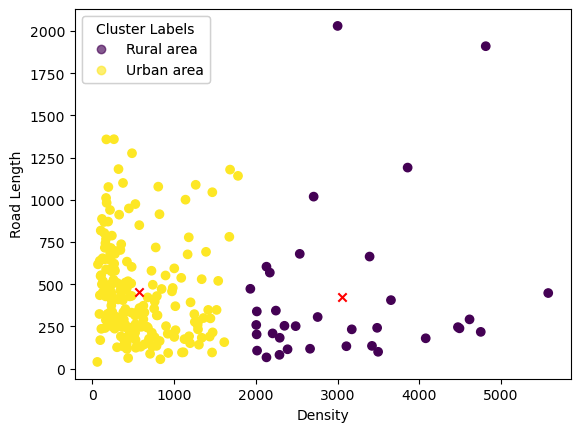

,Municipality_Name,Population,Area,Density,Road_Length,Accident_Count,Cluster_Name
0,Aa en Hunze,25579,276.66,93,639,21,Urban area
1,Almere,32452,20.00,1615,157,63,Urban area
2,Alblasserdam,20087,8.87,2290,82,20,Rural area
3,Albrandswaard,25934,21.17,1197,151,3,Urban area
4,Alkmaar,110783,110.01,1004,594,28,Urban area
...,...,...,...,...,...,...,...
229,Zoetermeer,125767,34.43,3653,406,36,Rural area
230,Zoeterwoude,9302,21.16,440,63,8,Urban area
231,Zuidplas,45794,57.76,790,316,59,Urban area
232,Zwijndrecht,44789,20.01,2206,209,13,Rural area


In [37]:
k = 2  # The number of clusters
kmeans = KMeans(n_clusters=k)

# Select numeric columns for clustering
numeric_data = df_merged_data[['Density', 'Road_Length']].values
kmeans.fit(numeric_data)
labels = kmeans.labels_  # This assigns each data point to a cluster
centers = kmeans.cluster_centers_  # These are the cluster centroids

# Map cluster labels to desired names
label_names = {0: 'Rural area', 1: 'Urban area'}
label_names_list = [label_names[label] for label in labels]
cluster_names = [label_names[label] for label in labels]

# Plotting
scatter = plt.scatter(numeric_data[:, 0], numeric_data[:, 1], c=labels, cmap='viridis', label=label_names_list)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', label='Cluster Centers')

# Add labels to the clusters in the legend
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend1 = plt.legend(handles, [label_names[0], label_names[1]], title='Cluster Labels')
plt.gca().add_artist(legend1)  # Add the legend to the existing plot

plt.xlabel('Density')
plt.ylabel('Road Length')
plt.show()

# Add the 'Cluster_Name' column to the DataFrame
df_merged_data['Cluster_Name'] = cluster_names
df_merged_data


#### c) T-test analysis

Rural area consists of 199 out of 234 cities in the data, while the rest is classified as urban area. The descriptive statistics data shows that urban area has higher average number of accidents compared to the rural area. To test whether this difference is statistically significant or not, we will perform a T-test analysis. T-test method is commonly used to check the significance of difference between the average of two populations. In this case, the two populations are urban and rural area.

The T-test results show that the higher number of accidents owned by urban area is statistically significant in comparison to rural area. Hence, in order to answer the research question, the identification of weather's impact to the number of accidents have to be performed separately for each city group.

In [38]:
# Give the name for the table
print('\033[1mDescriptive Statistics Data for each City Group created\033[0m')

# Descriptive Data: ACCIDENT COUNT
accident_descriptive = df_merged_data.groupby('Cluster_Name')['Accident_Count'].describe()
accident_descriptive = accident_descriptive.rename(columns={'count': 'Count', 'mean': 'Mean', 'std': 'Std', 'min': 'Min', '25%': '25%', '50%': '50% (Med)', '75%': '75%', 'max': 'Max'})

# Descriptive Data: POPULATION DENSITY
density_descriptive = df_merged_data.groupby('Cluster_Name')['Density'].describe()
density_descriptive = density_descriptive.rename(columns={'count': 'Count', 'mean': 'Mean', 'std': 'Std', 'min': 'Min', '25%': '25%', '50%': '50% (Med)', '75%': '75%', 'max': 'Max'})

# Descriptive Data: ROAD LENGTH
roadlength_descriptive = df_merged_data.groupby('Cluster_Name')['Road_Length'].describe()
roadlength_descriptive = roadlength_descriptive.rename(columns={'count': 'Count', 'mean': 'Mean', 'std': 'Std', 'min': 'Min', '25%': '25%', '50%': '50% (Med)', '75%': '75%', 'max': 'Max'})

# Concatenate the DataFrames
combined_descriptive = pd.concat([accident_descriptive, density_descriptive, roadlength_descriptive], keys=['ACCIDENT COUNT', 'POPULATION DENSITY', 'ROAD LENGTH'])

# Format 'Mean' and 'Std' columns to display one digit after the decimal point
combined_descriptive['Mean'] = combined_descriptive['Mean'].round(1)
combined_descriptive['Std'] = combined_descriptive['Std'].round(1)

# Display the combined DataFrame
combined_descriptive


Descriptive Statistics Data for each City Group created


Count    Mean     Std     Min     25%  \
                   Cluster_Name                                          
ACCIDENT COUNT     Rural area     35.0    62.3   111.7     1.0    13.5   
                   Urban area    199.0    25.3    28.1     1.0     9.0   
POPULATION DENSITY Rural area     35.0  3049.3  1000.6  1934.0  2226.0   
                   Urban area    199.0   575.4   417.3    63.0   244.0   
ROAD LENGTH        Rural area     35.0   424.3   461.4    67.0   181.5   
                   Urban area    199.0   451.2   283.8    40.0   245.0   

                                 50% (Med)     75%     Max  
                   Cluster_Name                             
ACCIDENT COUNT     Rural area         31.0    55.5   543.0  
                   Urban area         18.0    32.0   246.0  
POPULATION DENSITY Rural area       2708.0  3574.5  5576.0  
                   Urban area        432.0   790.5  1783.0  
ROAD LENGTH        Rural area        252.0   460.5  2030.0  
                   Urban area        374.0   589.0  1359.0

In [39]:
# Print hypothesis to test and confidence level used
print('\033[1mHYPOTHESIS\033[0m')
print('HO: Average road accident in Urban area = Average road accident in Rural area')
print('H1: Average road accident in Urban area ≠ Average road accident in Rural area')
print('\n')

print('\033[1mCONFIDENCE LEVEL\033[0m')
print('Alpha = 5%')
print('\n')

# Creating two population of data: Urban and Rural area
urban_data = merged_data[df_merged_data['Cluster_Name'] == 'Urban area']
rural_data = merged_data[df_merged_data['Cluster_Name'] == 'Rural area']

# Extract the 'Accident Count' data for each group
urban_accident_count = urban_data['Accident_Count']
rural_accident_count = rural_data['Accident_Count']

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(urban_accident_count, rural_accident_count)

# Print results
print('\033[1mT-TEST RESULTS\033[0m')
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.5f}")
print('\n')

# Determine whether the difference is statistically significant (using confidence level = 0.05)
print('\033[1mCONCLUSION\033[0m')
if p_value < 0.05:
    print("P_value < alpha, then H0 is rejected.")
else:
    print("P_value > alpha, then H0 is accepted.")

if p_value < 0.05:
    print("This hypothesis: 'Average road accident in Urban area ≠ Average road accident in Rural area' is accepted.")
else:
    print("This hypothesis: 'Average road accident in Urban area = Average road accident in Rural area' is accepted.")
    

HYPOTHESIS
HO: Average road accident in Urban area = Average road accident in Rural area
H1: Average road accident in Urban area ≠ Average road accident in Rural area


CONFIDENCE LEVEL
Alpha = 5%


T-TEST RESULTS
T-statistic: -4.04
P-value: 0.00007


CONCLUSION
P_value < alpha, then H0 is rejected.
This hypothesis: 'Average road accident in Urban area ≠ Average road accident in Rural area' is accepted.


In [40]:
'''
if urban_avg > rural_avg:
    print("Then, it's concluded that \033[1mUrban area has statistically higher average of road accident than Rural area.\033[0m")
else:
    print("Then, it's concluded that \033[1mRural area has statistically higher average of road accident than Urban area.\033[0m")
'''

'\nif urban_avg > rural_avg:\n    print("Then, it\'s concluded that \x1bUrban area has statistically higher average of road accident than Rural area.\x1b")\nelse:\n    print("Then, it\'s concluded that \x1bRural area has statistically higher average of road accident than Urban area.\x1b")\n'

In [41]:
# Creating new dataset from df_accidents which aggregating tne number of accident by weather_type
df_accident_weather_agg = df_accidents.groupby(['Municipality','Weather_Type']).size().reset_index(name='Accident_Count')
df_accident_weather_agg = df_accident_weather_agg.sort_values(by=['Municipality','Weather_Type'])

# Get the filtered cluster name data per municipality
df_clustered_area = df_merged_data[['Municipality_Name','Cluster_Name']]

# Merge the two DataFrames on the 'Municipality' and 'Municipality_Name' columns
merged_data_2 = df_accident_weather_agg.merge(df_clustered_area, left_on='Municipality', right_on='Municipality_Name', how='left')

# Drop the redundant 'Municipality_Name' column
df_cluster_weather_data = merged_data_2.drop(columns='Municipality_Name')
df_cluster_weather_data = df_cluster_weather_data.sort_values(by=['Municipality', 'Weather_Type'])

df_cluster_weather_cleaned = df_cluster_weather_data.dropna()

# Create new column for accident_percentage
total_accident_counts = df_cluster_weather_cleaned.groupby('Municipality')['Accident_Count'].transform('sum')

# Calculate the accident percentage and add it to the dataframe
df_cluster_weather_cleaned['Accident_Percentage'] = (df_cluster_weather_cleaned['Accident_Count'] / total_accident_counts) * 100
df_cluster_weather_cleaned


C:\Users\simon\AppData\Local\Temp\ipykernel_14036\2197853070.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Municipality,Weather_Type,Accident_Count,Cluster_Name,Accident_Percentage
6,Aa en Hunze,D,18,Urban area,85.714286
7,Aa en Hunze,R,3,Urban area,14.285714
8,Alblasserdam,D,20,Rural area,100.000000
9,Albrandswaard,D,2,Urban area,66.666667
10,Albrandswaard,R,1,Urban area,33.333333
...,...,...,...,...,...
576,Zuidplas,M,1,Urban area,1.694915
577,Zuidplas,R,4,Urban area,6.779661
578,Zwijndrecht,D,13,Rural area,100.000000
579,Zwolle,D,46,Urban area,85.185185


#### b) Performing the analysis

The ANOVA results show that there are significant difference of accident percentage between weather type groups, both in urban area as well as rural area. Dry weather has highest accident percentage, followed by Fog, Rain, Wind and Snow in Rural area. Meanwhile, in Urban area, Dry weather also has the highest accident percentage, but then followed by Rain, Snow, Wind and Fog in the last.

In [42]:
# Print hypothesis to test and confidence level used
print('\033[1mHYPOTHESIS\033[0m')
print('HO: There is no difference of the average of accident percentage among weather type.')
print('H1: There is significant difference of the average of accident percentage among weather type.')
print('\n')

print('\033[1mCONFIDENCE LEVEL\033[0m')
print('Alpha = 5%')
print('\n')

# Define the dictionary to map old values to new values
weather_name = {'D': 'Dry', 'R': 'Rain', 'M': 'Fog', 'S': 'Snow', 'H': 'Wind', 'O': 'Unknown'}

# Apply the mapping to the 'Weather_Type' column
df_cluster_weather_cleaned['Weather_Type'] = df_cluster_weather_cleaned['Weather_Type'].replace(weather_name)

# Create subsets of the data for each cluster
cluster_names = df_cluster_weather_cleaned['Cluster_Name'].unique()
    
print('\033[1mANOVA TEST RESULTS AND CONCLUSION\033[0m')

for cluster_name in cluster_names:
    subset = df_cluster_weather_cleaned[df_cluster_weather_cleaned['Cluster_Name'] == cluster_name]
    
   # Perform one-way ANOVA for each cluster
    unique_weather_types = sorted(subset['Weather_Type'].unique())  # Sort weather types alphabetically
    weather_groups = [subset[subset['Weather_Type'] == weather]['Accident_Percentage'] for weather in subset['Weather_Type'].unique()]
    
    # Perform the ANOVA test
    f_statistic, p_value = f_oneway(*weather_groups)
    
    # Calculate and display the average for each weather type
    averages = [f'{group.mean():.2f}' for group in weather_groups]
    
    # Determine whether the difference is statistically significant (using confidence level = 0.05)
    print(f"\033[1mCluster Name: {cluster_name.upper()}\033[0m")
    print("Average number of accident percentage per weather type:")
    
    sorted_weather_averages = sorted(zip(unique_weather_types, averages), key=lambda x: x[0])
    for weather_type, avg in sorted_weather_averages:
        print(f"   {weather_type} = {avg}")
        
    print(f"P-value: {p_value:.5f}")
    # print t-value as well 
    
    print(f"\033[1mConclusion:\033[0m")
    if p_value < 0.05:
        print("P_value < alpha, then H0 is rejected.")
    else:
        print("P_value > alpha, then H0 is accepted.")
        
    if p_value < 0.05:  
        print(f"Then, it's concluded that there is \033[1msignificant difference of the average of accident percentage among weather type.\033[0m")
    else:
        print(f"Then, it's concluded that there is \033[1mno significant difference of the average of accident percentage among weather type.\033[0m")
    print()


HYPOTHESIS
HO: There is no difference of the average of accident percentage among weather type.
H1: There is significant difference of the average of accident percentage among weather type.


CONFIDENCE LEVEL
Alpha = 5%


ANOVA TEST RESULTS AND CONCLUSION
Cluster Name: URBAN AREA
Average number of accident percentage per weather type:
   Dry = 84.91
   Fog = 13.75
   Rain = 6.54
   Snow = 3.18
   Wind = 5.78
P-value: 0.00000
Conclusion:
P_value < alpha, then H0 is rejected.
Then, it's concluded that there is significant difference of the average of accident percentage among weather type.

Cluster Name: RURAL AREA
Average number of accident percentage per weather type:
   Dry = 89.49
   Fog = 0.75
   Rain = 11.98
   Snow = 2.69
   Wind = 1.30
P-value: 0.00000
Conclusion:
P_value < alpha, then H0 is rejected.
Then, it's concluded that there is significant difference of the average of accident percentage among weather type.



C:\Users\simon\AppData\Local\Temp\ipykernel_14036\1495665879.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Question 2: Impact of Weather to Road Accidents Severity



### Chi-Square Analysis

We will use chi-square test to examine the impact weather to accident severity. This method is chosen because it allows us to identify the correlation between two categorical groups of data. In this case, both weather type and accident severity data are categorical.

The results show that there is no significant association / correlation between weather type and accident severity. It means the number of accidents is equally spread across all severity level regardless the weather type.

In [44]:
# Print hypothesis to test and confidence level used
print('\033[1mHYPOTHESIS\033[0m')
print('HO: Accident severity and Weather type have no association.')
print('H1: Accident severity and Weather type have significant association.')
print('\n')

print('\033[1mCONFIDENCE LEVEL\033[0m')
print('Alpha = 5%')
print('\n')

# Creating new dataset that aggregating accidents by Weather_Type and Severity
df_weather_severity_agg = df_accidents.groupby(['Weather_Type','Severity']).size().reset_index(name='Accident_Count')
df_weather_severity_agg = df_weather_severity_agg.sort_values(by=['Weather_Type','Severity'])

# Create a dictionary for abbreviation contained in the data
weather_name = {'D': 'Dry', 'R': 'Rain', 'M': 'Fog', 'S': 'Snow', 'H': 'Wind', 'O': 'Unknown'}
severity = {'DOD': 'Deadly', 'LET': 'Injury', 'UMS': 'Material damage'}

# Apply the mapping to the 'Weather_Type' column
df_weather_severity_agg['Weather_Type'] = df_weather_severity_agg['Weather_Type'].replace(weather_name)
df_weather_severity_agg['Severity'] = df_weather_severity_agg['Severity'].replace(severity)

# Create a contingency table for 'Weather_Type' and 'Severity'
contingency_table = pd.crosstab(df_weather_severity_agg['Weather_Type'], df_weather_severity_agg['Severity'])

# Perform the chi-square test of independence
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Determine whether the difference is statistically significant (using confidence level = 0.05)
print('\033[1mCHI-SQUARE TEST RESULTS\033[0m')
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.4f}")
print('\n')

print('\033[1mCONCLUSION\033[0m')
if p_value < 0.05:
    print("P_value < alpha, then H0 is rejected.")
else:
    print("P_value > alpha, then H0 is accepted.")

if p_value < 0.05: 
    print("Then, it's concluded that there is \033[1msignificant association between Weather Type and Accident Severity.\033[0m")
else:
    print("Then, it's concluded that there is \033[1mno significant association between Weather Type and Accident Severity.\033[0m")


HYPOTHESIS
HO: Accident severity and Weather type have no association.
H1: Accident severity and Weather type have significant association.


CONFIDENCE LEVEL
Alpha = 5%


CHI-SQUARE TEST RESULTS
Chi-square statistic: 2.93
P-value: 0.9385


CONCLUSION
P_value > alpha, then H0 is accepted.
Then, it's concluded that there is no significant association between Weather Type and Accident Severity.
